+-------------------+--------------------+------+--------+--------+----+--------------------+----+--------------------+
|               date|        primary_type|arrest|domestic|district|year|         description|iucr|location_description|
+-------------------+--------------------+------+--------+--------+----+--------------------+----+--------------------+
|2021-05-12 00:00:00|CRIMINAL SEXUAL A...| false|   false|       1|2021|      NON-AGGRAVATED|0281|               ALLEY|
|2019-02-04 23:00:00|CRIMINAL SEXUAL A...| false|   false|       1|2019|      NON-AGGRAVATED|0281|       HOTEL / MOTEL|
|2025-05-21 21:00:00|             ROBBERY| false|   false|       1|2025|ARMED - KNIFE / C...|0312|            SIDEWALK|
|2025-03-30 15:20:00|             ROBBERY| false|   false|       1|2025|ARMED - OTHER DAN...|0313|   CONVENIENCE STORE|
|2015-01-29 00:50:00|             ROBBERY| false|   false|       1|2015|      ARMED: HANDGUN|031A|               OTHER|
|2024-09-29 17:00:00|             ROBBER

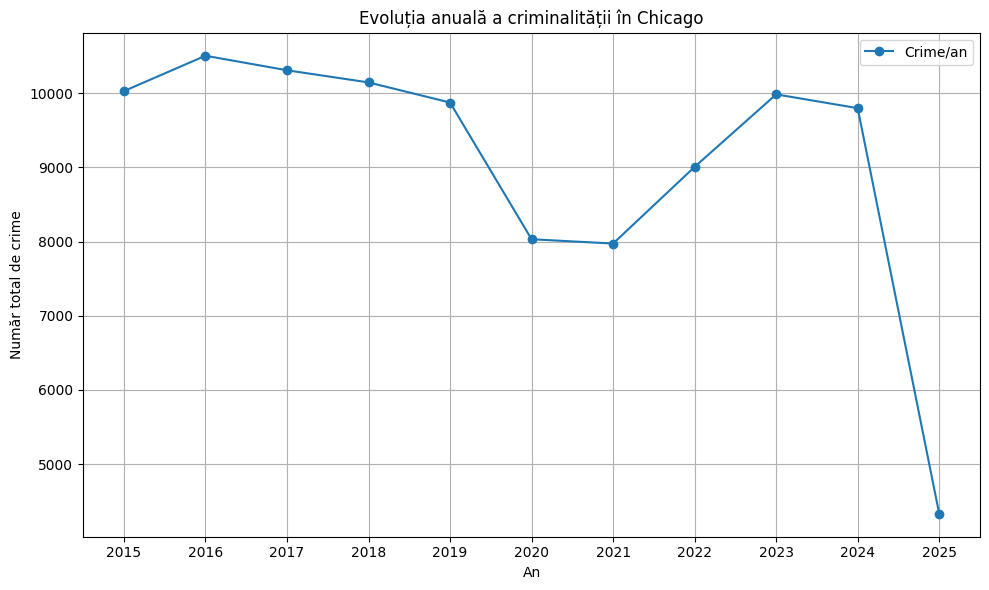

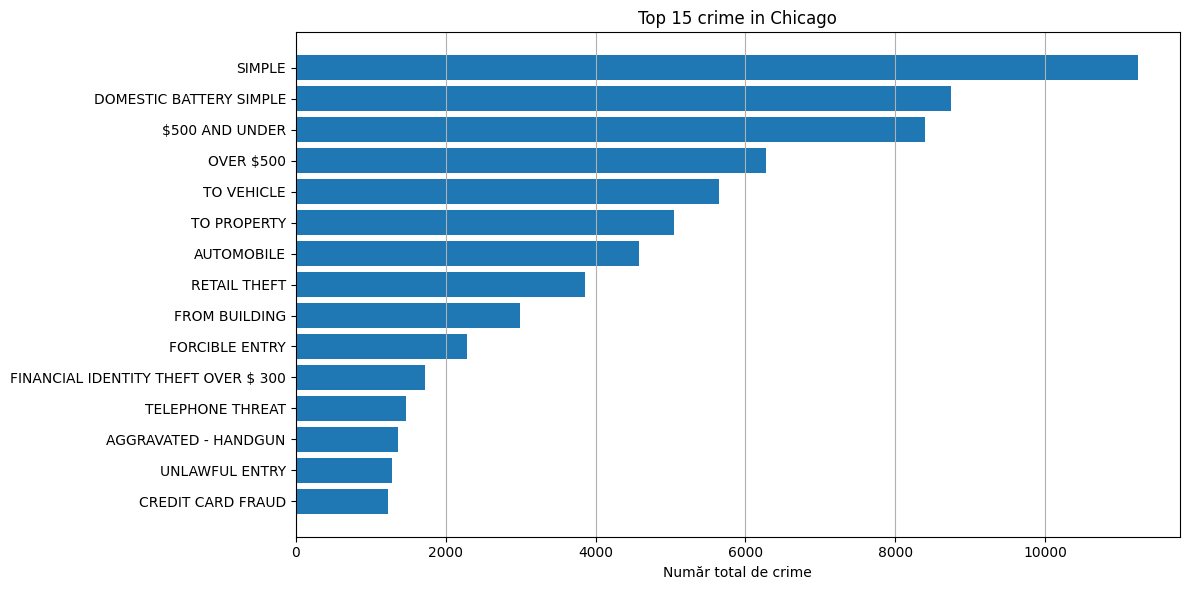

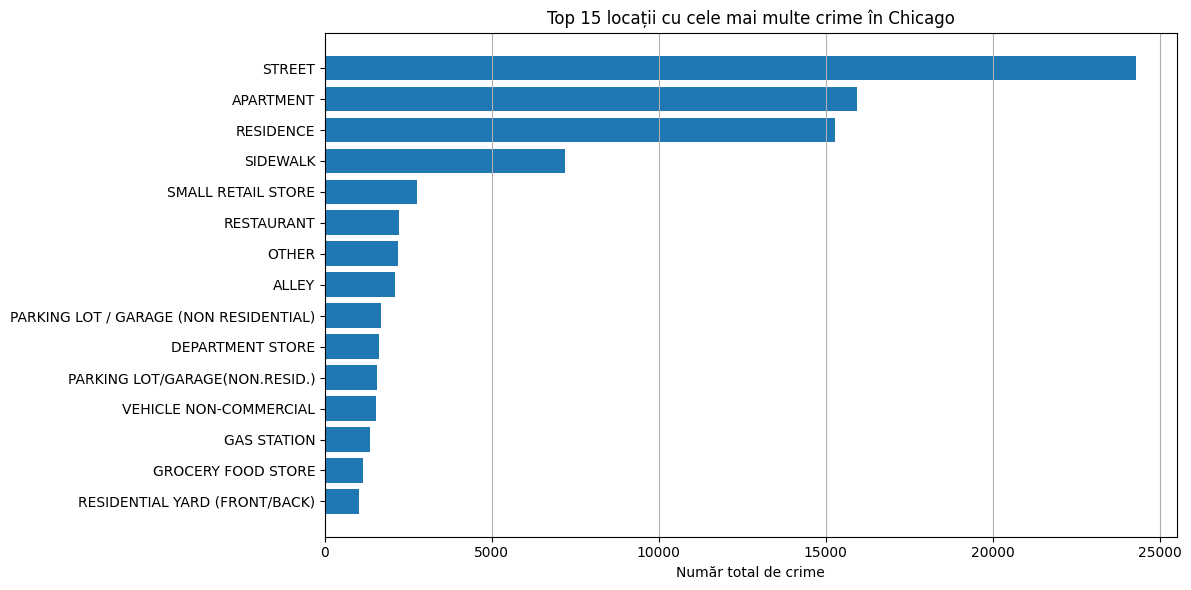

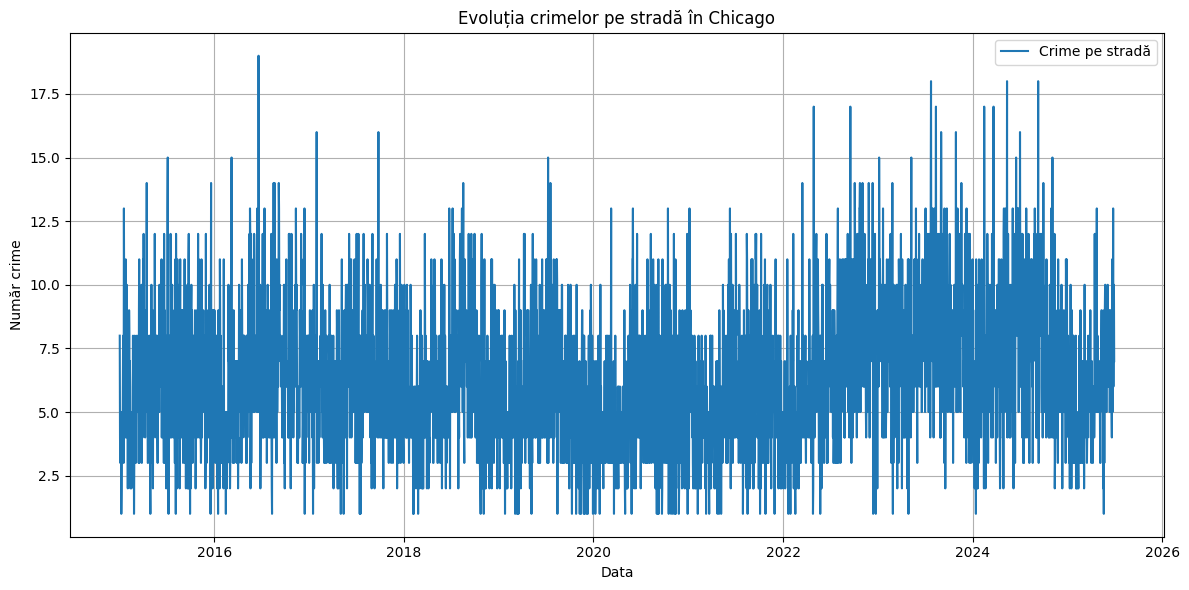

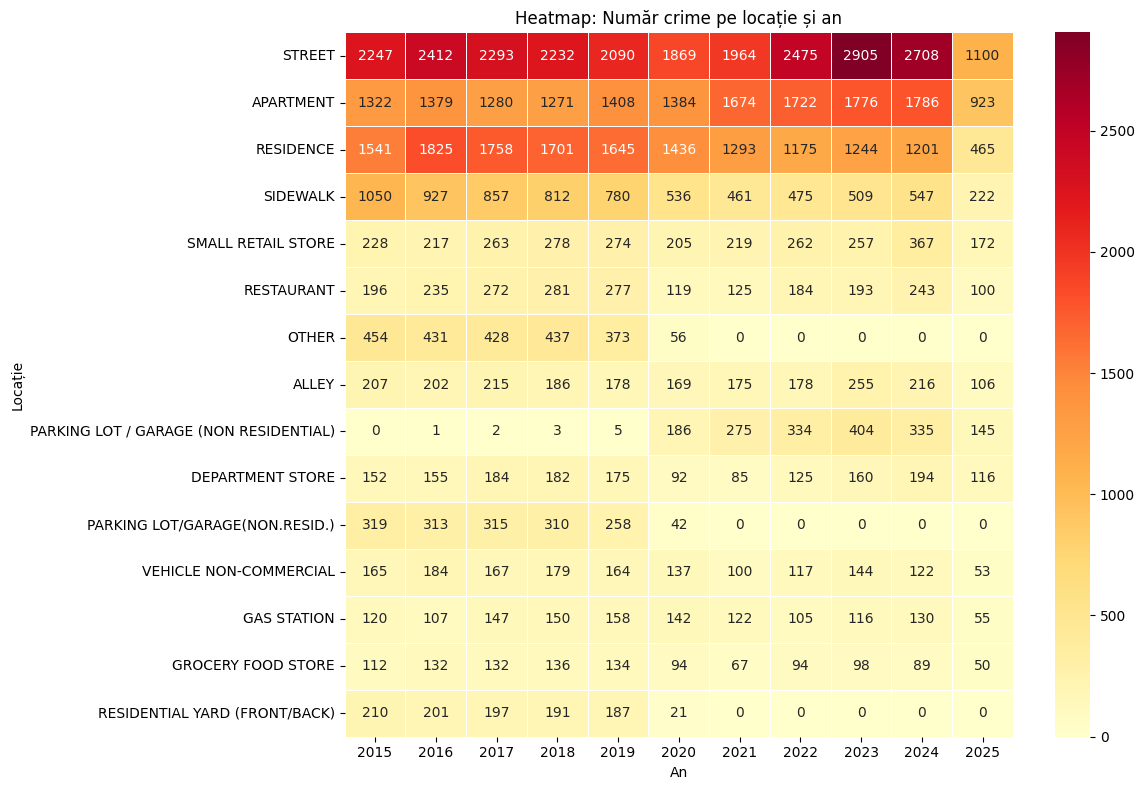

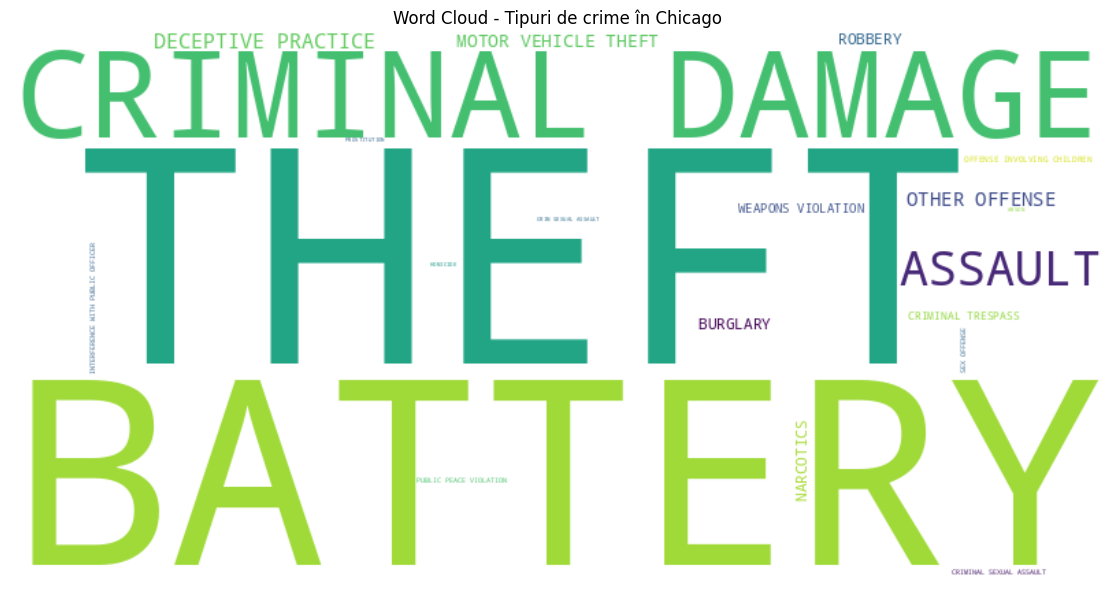

In [9]:
from google.cloud import bigquery
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

client = bigquery.Client()
spark = SparkSession.builder.appName("Chicago Crimes").getOrCreate()

query = """
SELECT date, primary_type, arrest, domestic, district, year, description, iucr, location_description
FROM `bigquery-public-data.chicago_crime.crime`
WHERE year BETWEEN 2015 AND 2025
limit 100000;
"""

df = client.query(query).to_dataframe()
spark_df = spark.createDataFrame(df)
spark_df.show(10)

pandas_df = spark_df.toPandas()

#1 Evoluția zilnică a criminalității în Chicago
pandas_df["date"] = pd.to_datetime(pandas_df["date"])
pandas_df["date_only"] = pandas_df["date"].dt.date

crime_counts_per_year = pandas_df.groupby("year").size().reset_index(name="crime_count")
plt.figure(figsize=(10, 6))
plt.plot(crime_counts_per_year["year"], crime_counts_per_year["crime_count"], marker='o', label="Crime/an")
plt.xlabel("An")
plt.ylabel("Număr total de crime")
plt.title("Evoluția anuală a criminalității în Chicago")
plt.xticks(crime_counts_per_year["year"])  # afisează fiecare an pe axa X
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#2 Top 15 crime in Chicago
description_crime_counts = pandas_df.dropna(subset=["description"])
description_crime_counts = (
    description_crime_counts.groupby("description")
    .size()
    .reset_index(name="crime_count")
    .sort_values("crime_count", ascending=False)
)
top_descriptions = description_crime_counts.head(15)
plt.figure(figsize=(12, 6))
plt.barh(top_descriptions["description"], top_descriptions["crime_count"])
plt.xlabel("Număr total de crime")
plt.title("Top 15 crime in Chicago")
plt.gca().invert_yaxis()  # cele mai frecvente sus
plt.grid(axis="x")
plt.tight_layout()
plt.show()

#3 Top 15 locații cu cele mai multe crime în Chicag
location_crime_counts = pandas_df.dropna(subset=["location_description"])
location_crime_counts = (
    location_crime_counts.groupby("location_description")
    .size()
    .reset_index(name="crime_count")
    .sort_values("crime_count", ascending=False)
)
top_locations = location_crime_counts.head(15)
plt.figure(figsize=(12, 6))
plt.barh(top_locations["location_description"], top_locations["crime_count"])
plt.xlabel("Număr total de crime")
plt.title("Top 15 locații cu cele mai multe crime în Chicago")
plt.gca().invert_yaxis()  # cele mai frecvente sus
plt.grid(axis="x")
plt.tight_layout()
plt.show()

#4 Evoluția crimelor pe stradă în Chicago
pandas_df["date"] = pd.to_datetime(pandas_df["date"])
pandas_df["date_only"] = pandas_df["date"].dt.date
street_crimes = pandas_df[pandas_df["location_description"] == "STREET"]
street_crimes_per_day = (
    street_crimes.groupby("date_only")
    .size()
    .reset_index(name="crime_count")
    .sort_values("date_only")
)
plt.figure(figsize=(12, 6))
plt.plot(street_crimes_per_day["date_only"], street_crimes_per_day["crime_count"], label="Crime pe stradă")
plt.xlabel("Data")
plt.ylabel("Număr crime")
plt.title("Evoluția crimelor pe stradă în Chicago")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#5 Heatmap cu cele mai frecvente 15 locații
heatmap_data = pandas_df.dropna(subset=["location_description", "year"])
pivot_table = heatmap_data.pivot_table(
    index="location_description",
    columns="year",
    aggfunc="size",
    fill_value=0
)
top_locations = pivot_table.sum(axis=1).sort_values(ascending=False).head(15).index
filtered_pivot = pivot_table.loc[top_locations]
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_pivot, cmap="YlOrRd", linewidths=0.5, annot=True, fmt="d")
plt.title("Heatmap: Număr crime pe locație și an")
plt.xlabel("An")
plt.ylabel("Locație")
plt.tight_layout()
plt.show()

#6 Wordcloud pnetru a evidentia densitatea crimelor pentru fiecare tip
type_counts = pandas_df["primary_type"].value_counts().to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(type_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Tipuri de crime în Chicago")
plt.tight_layout()
plt.show()